# NEAT - NeuroEvolution of Augmenting Topologies

## Motivation and idea

Most neural networks are trained using gradient-based optimization like backpropagation. This approach requires:
- Differentiable activation functions,
- Continuous loss functions,
- Fixed network topology.

Many problems, especially those involving control, sparse or delayed rewards, or discrete decision-making like some reinforcement learning problems make gradient-based training difficult or unstable.

Neuroevolution offers an alternative: instead of adjusting weights using gradients, we treat the entire network as an individual in a population and proceed to evole the population (network topologies, weights or both) using standard principles of genetic algorithms - selection, crossover, mutations.

In essence, instead of optimizing the netwarks using calculus we search for good networks using a genetic algorithm.

## NEAT

NEAT is a neuroevolution algorithm designed to evolve both weights and topology of the network introduced by Kenneth O. Stanley & Risto Miikkulainen in their paper [Efficient Evolution of Neural Network Topologies](https://nn.cs.utexas.edu/downloads/papers/stanley.cec02.pdf).

NEAT works by maintaining a popolation of neural networks, each with its own topology and weights. These networks are evaluated on a given task, assigned a fitness score and then selectively bred through crossover and mutation to form the next generation of networks.

The key ideas that make NEAT different compared to standard genetic algorithms or other neuroevolution algorithms are historical markings, where every new topological innovation receives a unique innovation number, making it possible to align different network topologies during crossover without confusion, and the idea to protect innovation, i.e maintaining diversity by letting newly mutated networks have time to prove their worth by only comparing them within their own species before competing globally.

### Genotype representation in NEAT

Each netowrk in NEAT can be represented as a genotype containing a list of node genes and connection genes. Node genes containing information about network nodes, connection genes containing information about connectins such as input node, output node, connection weight.

<center><img src="./images/genotype.png"/></center>

The mapping from genotype to phenotype is deterministic: every gene precisely defines how the corresponding network will be structured and behave.

### Historical markings (innovation numbers) and crossover

A central concept that makes NEAT efficient and stable during evolution is its system of historical markings. These numbers serve as a unique record of how each structural feature of a network came into existence.

When a new structural mutation occurs NEAT assigns it a new innovation number. This number acts like a genetic timestamp that records the order of discovery for every new connection gene.

Without innovation numbers, it would be difficult to align genes between two parent networks during crossover, especially when their topologies differ. NEAT uses innovation numbers to ensure that corresponding genes from different genomes can be matched correctly, even if the networks have evolved independently for many generations.

--------------

When two genomes reproduce, NEAT aligns their genes using innovation numbers. Genes are classified as:
- Matching: present in both parents (same innovation ID).
- Disjoint: present in one parent but missing in the middle of the other’s innovation range.
- Excess: present in one parent but beyond the other’s maximum innovation ID.

The offspring inherits matching genes randomly and nonmatching genes from the fitter parent. This preserves meaningful structure during crossover, even when networks differ in size or shape.

For example:
<center><img src="images/markings.png"/></center>
Here, although Parent 1 and Parent 2 look different, their innovation numbers (shown at the top of each gene) tell us which genes match up with which without the need for topological analysis.

### Mutations

Mutation in NEAT can change both connection weights and network structures. 

Connection weights mutate as in any NE system, with each connection either perturbed or not.
$$ w' = w + \mathcal{N}(0, \sigma^{2}) $$

Structural mutations, which expand the genome, occur in two ways:
- In the add connection mutation, a single new connection gene is added connecting two previously unconnected nodes <center><img src="images/add_connection.png"/></center>
- In the add node mutation an existing connection is split and the new node placed where the old connection used to be. The old connection is disabled and two new connections are added to the genome. <center><img src="images/add_node.png"/></center>

### Speciation and compatibility distance

To prevent new, innovative structures from being immediately outcompeted by older, optimized ones, NEAT groups similar genomes into species. Within a species, individuals compete only with each other.

Similarity is measured by compatibility distance:

$$ \delta(g_{a}, g_{b}) = \frac{c_{1}E(g_{a}, g_{b})}{N} + \frac{c_{2}D(g_{a}, g_{b})}{N} + c_{3}\overline{W}(g_{a}, g_{b}) $$

Where:
- $E(g_{a}, g_{b})$ - Excess genes
- $D(g_{a}, g_{b})$ - Disjoint genes
- $\overline{W}(g_{a}, g_{b})$ - average weight difference of matching genes
- $N$ - Number of genes in the larger genome
- $c_{1}, c_{2}, c_{3}$ - importance factors

Two networks belong to the same species if $\delta < \delta_{threshold}$. Every genome is placed into the first species for which this condition is satisfied, so that no network can belong to two different species.


The size of each species is determined by comparing averge fitness of the species compared to global population fitness, i.e at each step the size of given species is determined by the following formula:

$$ N'_{j} = \frac{\sum_{i=1}^{N_{j}}f_{ij}}{f} $$

Where:
- $N_{j}$ and $N'_{j}$ are the old and new number of individuals in species j
- $f_{ij}$ is the adjusted fitness of individual $i$ in species $j$
- $f$ is the mean adjusted fitness in the entire population

During crossover the best performing $r\%$ of each species is randomly mated to generate $N'_{j}$ offspring, which replaces the entire population of the species.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import time
import neat
import visualize

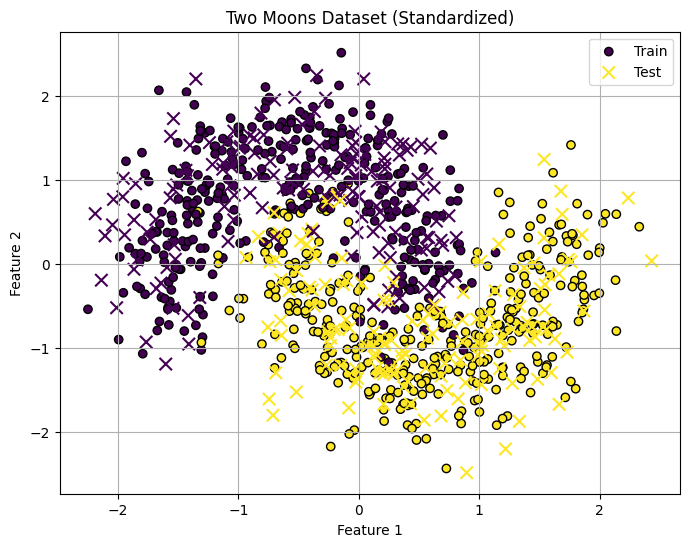

Training set shape: X=(700, 2), y=(700,)
Test set shape: X=(300, 2), y=(300,)


In [2]:
X, y = make_moons(n_samples=1000, noise=0.25, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, edgecolors="k", label="Train"
)
plt.scatter(
    X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, marker="x", s=80, label="Test"
)
plt.title("Two Moons Dataset (Standardized)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

print(f"Training set shape: X={X_train_scaled.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test_scaled.shape}, y={y_test.shape}")



In [3]:
def fitness_function(nn_output: np.ndarray, true_data: np.ndarray) -> np.ndarray:
    accuracy = (nn_output == true_data).astype(float).mean()
    return accuracy

In [4]:
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        outputs = np.array([net.activate(x)[0] > 0.5 for x in X_train]).astype(int)
        genome.fitness = fitness_function(outputs, y_train)

In [5]:
def run(config_filename):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation, config_filename)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(False))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))

    # Run for up to 300 generations.
    winner = p.run(eval_genomes, 300)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))

    # Show output of the most fit genome against training data.
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(X_test, y_test):
        output = winner_net.activate(xi)
        #print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    #p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    #p.run(eval_genomes, 10)
    return winner, stats

In [7]:
import pickle
winner, stats = run('config')

with open("winner_genome.pkl", "wb") as f:
    pickle.dump(winner, f)

with open("stats.pkl", "wb") as f:
    pickle.dump(stats, f)


 ****** Running generation 0 ****** 

Population's average fitness: 0.48885 stdev: 0.18338
Best fitness: 0.84571 - size: (1, 2) - species 1 - id 32
Average adjusted fitness: 0.346
Mean genetic distance 1.145, standard deviation 0.402
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 0.139 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.62859 stdev: 0.14436
Best fitness: 0.85429 - size: (1, 2) - species 1 - id 203
Average adjusted fitness: 0.430
Mean genetic distance 1.089, standard deviation 0.459
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 0.122 sec (0.131 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.65763 stdev: 0.14864
Best fitness: 0.85714 - size: (1, 2) - species 1 - id 359
Average adjusted fitness: 0.452
Mean genetic distance 1.082, standard deviation 0.440
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 0.116 sec (0.126 average)


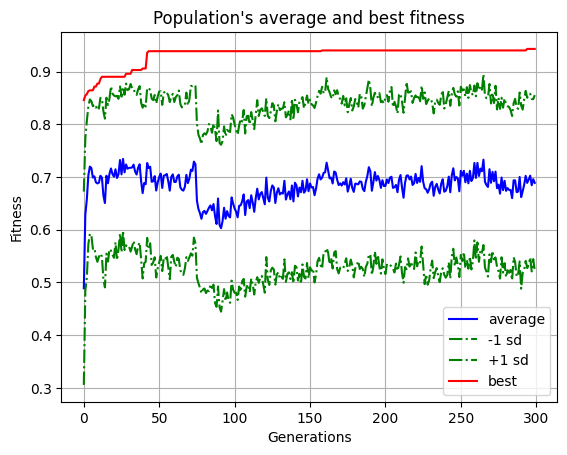

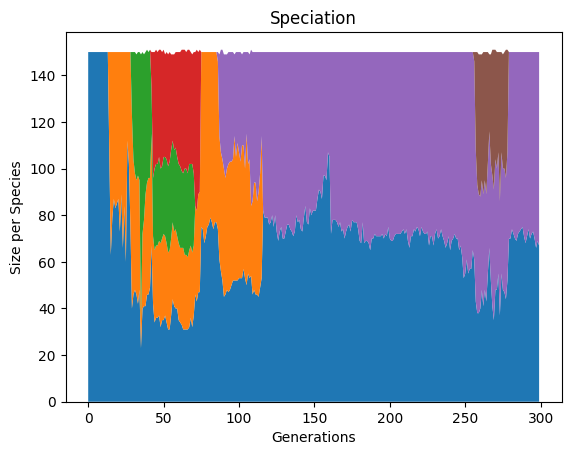

In [8]:
from IPython.display import Image, SVG, display
import pickle

config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation, 'config')

with open("winner_genome.pkl", "rb") as f:
    winner = pickle.load(f)

with open("stats.pkl", "rb") as f:
    stats = pickle.load(f)
    
node_names = {-1: 'x', -2: 'y'}
visualize.draw_net(config, winner, view=True, node_names=node_names)
visualize.plot_stats(stats, ylog=False, view=True)

visualize.plot_species(stats, view=True) 

# Reinforcement learning examples

In [3]:
import os
from typing import Any
import gymnasium as gym
from tqdm import tqdm
import neat
import visualize
import imageio
import numpy as np
import pickle
import copy
from IPython.display import Image, SVG, display

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [13]:
def eval_genomes(genomes, config, env, run_with_single_net_f):
    for genome_id, genome in genomes:
        eval_env = copy.deepcopy(env)
        eval_env.reset()
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = run_with_single_net_f(net, eval_env)
        env.close()

In [14]:
def main(config_filename, env_name, eval_function, output_dir, checkpoint=None, generations=200) -> None:
    os.makedirs(output_dir, exist_ok=True)
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation, config_filename)
    
    if checkpoint:
        print(f"Restoring from checkpoint: {checkpoint}")
        p = neat.Checkpointer.restore_checkpoint(checkpoint)
    else:
        p = neat.Population(config)
    
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5, filename_prefix=os.path.join(output_dir, 'neat-checkpoint-')))
    
    winner = p.run(lambda g, c: eval_genomes(g, c, env_name, eval_function), generations)
    
    print('\nBest genome:\n{!s}'.format(winner))
    
    with open(f"{output_dir}/winner_genome.pkl", "wb") as f:
        pickle.dump(winner, f)
    
    visualize.draw_net(config, winner, view=False, filename=os.path.join(output_dir, 'best_network'))
    visualize.plot_stats(stats, ylog=False, view=False, filename=os.path.join(output_dir, 'fitness_progress.svg'))
    visualize.plot_species(stats, view=False, filename=os.path.join(output_dir, 'species_evolution.svg'))
    
    print(f"results saved in '{output_dir}' directory")

## CartPole

In [30]:
def run_with_single_net_cartpole(net: Any, environment, max_steps=5000, N_EXPERIMENTS = 10):
    reward_sum = 0.0

    for _ in range(N_EXPERIMENTS):
        done = False
        state, info = environment.reset()
        step = 0
        while not done:
            output = net.activate(state)
            action = max(enumerate(output), key=lambda x: x[1])[0]
            state, reward, done, truncated, info = environment.step(action)
            step += 1
            reward_sum += reward
            if step >= max_steps:
                break
                
    return reward_sum / N_EXPERIMENTS

In [31]:
env = gym.make('CartPole-v1', render_mode=None)
main("config_cartpole", env, run_with_single_net_cartpole, output_dir = "reinforcement/cartpole", checkpoint=None)


 ****** Running generation 0 ****** 

Population's average fitness: 34.31200 stdev: 221.09800
Best fitness: 3695.40000 - size: (2, 8) - species 1 - id 8
Average adjusted fitness: 0.007
Mean genetic distance 1.203, standard deviation 0.288
Population of 300 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   300   3695.4    0.007     0
Total extinctions: 0
Generation time: 1.108 sec

 ****** Running generation 1 ****** 

Population's average fitness: 64.92933 stdev: 310.41641
Best fitness: 3653.40000 - size: (2, 8) - species 1 - id 8
Average adjusted fitness: 0.015
Mean genetic distance 1.238, standard deviation 0.269
Population of 300 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   300   3653.4    0.015     1
Total extinctions: 0
Generation time: 1.869 sec (1.489 average)

 ****** Running generation 2 ****** 

Population's average fitness: 138.370

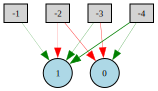

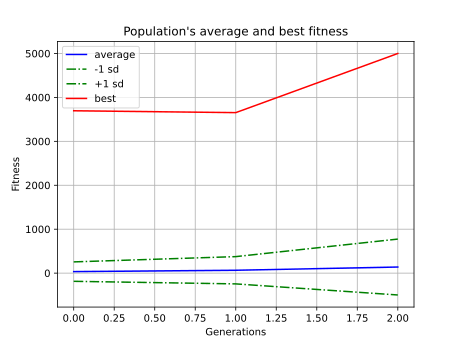

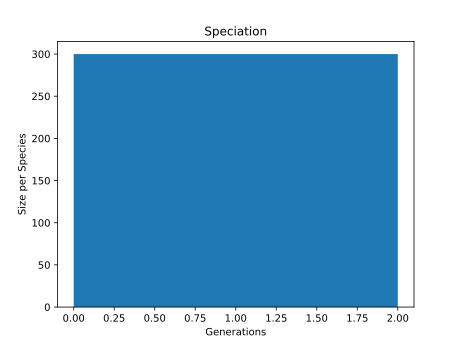

In [32]:
env_name = "cartpole"
display(SVG(filename=f"reinforcement/{env_name}/best_network.svg"))
display(SVG(filename=f"reinforcement/{env_name}/fitness_progress.svg"))
display(SVG(filename=f"reinforcement/{env_name}/species_evolution.svg"))

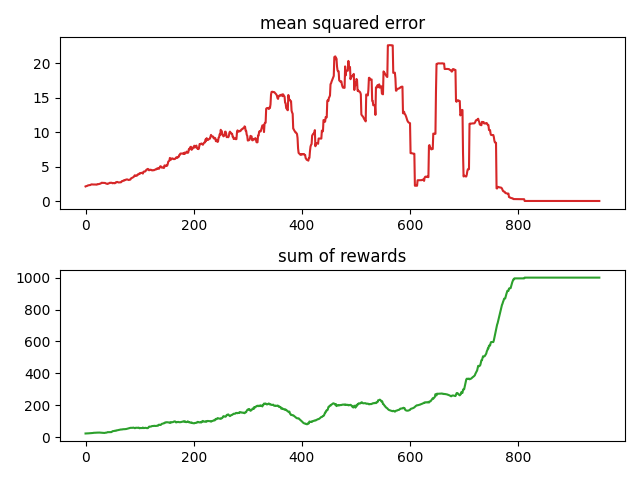

In [33]:
display(Image(filename=f"images/cartpole_plot.png"))

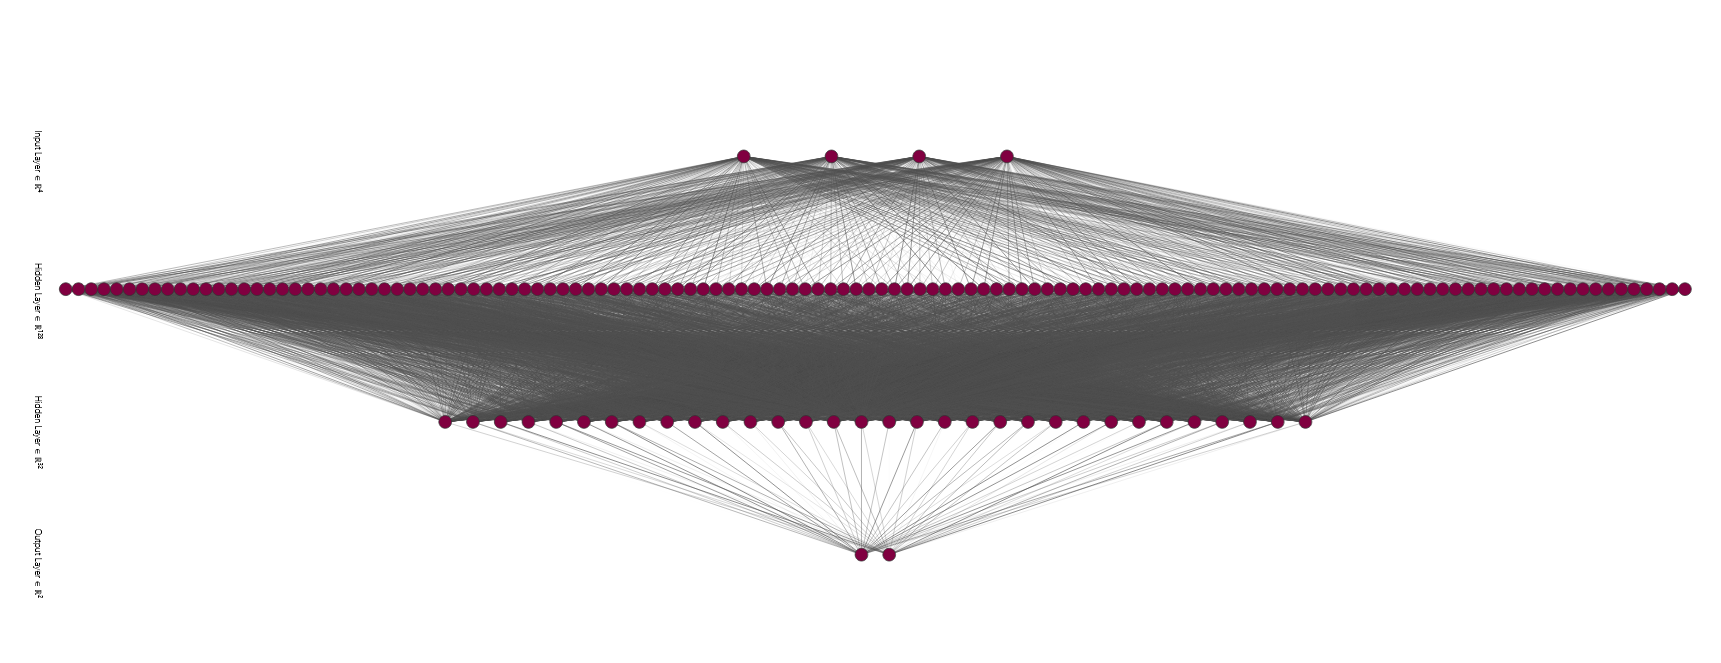

In [34]:
display(Image(filename=f"images/cartpole_net1.png"))

In [35]:
with open("reinforcement/cartpole/winner_genome.pkl", "rb") as f:
    winner = pickle.load(f)

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    "config_cartpole"
)

net = neat.nn.FeedForwardNetwork.create(winner, config)

env = gym.make('CartPole-v1', render_mode='human')
state, _ = env.reset()
done = False
step = 0
while not done:
    env.render()
    output = net.activate(state)
    action = max(enumerate(output), key=lambda x: x[1])[0]
    state, reward, done, truncated, info = env.step(action)
    step += 1
    if step >= 500:
        break

env.close()

## Lunar lander

In [38]:
def run_with_single_net_lander(net: Any, environment, max_steps=5000, N_EXPERIMENTS = 10):
    reward_sum = 0.0

    for _ in range(N_EXPERIMENTS):
        done = False
        state, info = environment.reset()
        step = 0
        while not done:
            output = net.activate(state)
            action = max(enumerate(output), key=lambda x: x[1])[0]
            state, reward, done, truncated, info = environment.step(action)
            step += 1
            reward_sum += reward
            if step >= max_steps or reward < -200:
                break

    return reward_sum / N_EXPERIMENTS

env = gym.make('LunarLander-v3', render_mode=None)
main("config_lunar_lander", env, run_with_single_net_lander, output_dir = "reinforcement/lander", checkpoint=None)


 ****** Running generation 0 ****** 

Population's average fitness: -494.58401 stdev: 273.58869
Best fitness: -60.22559 - size: (4, 32) - species 1 - id 91
Average adjusted fitness: 0.772
Mean genetic distance 1.434, standard deviation 0.241
Population of 500 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   500    -60.2    0.772     0
Total extinctions: 0
Generation time: 13.214 sec

 ****** Running generation 1 ****** 

Population's average fitness: -310.48930 stdev: 210.83625
Best fitness: -64.39003 - size: (4, 32) - species 1 - id 91
Average adjusted fitness: 0.843
Mean genetic distance 1.561, standard deviation 0.232
Population of 500 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   500    -64.4    0.843     1
Total extinctions: 0
Generation time: 11.841 sec (12.528 average)

 ****** Running generation 2 ****** 

Population's average fitness

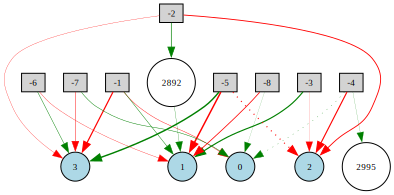

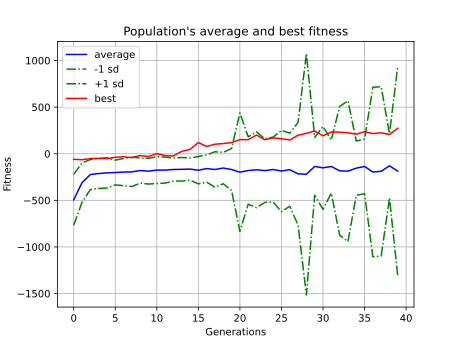

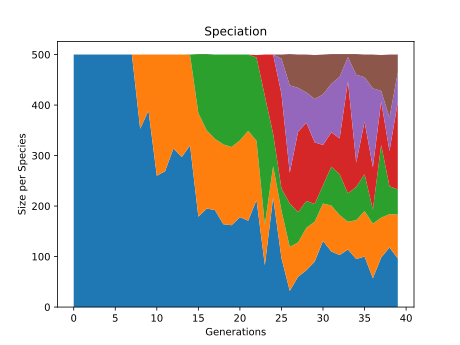

In [39]:
env_name = "lander"
display(SVG(filename=f"reinforcement/{env_name}/best_network.svg"))
display(SVG(filename=f"reinforcement/{env_name}/fitness_progress.svg"))
display(SVG(filename=f"reinforcement/{env_name}/species_evolution.svg"))

In [42]:
with open("reinforcement/lander/winner_genome.pkl", "rb") as f:
    winner = pickle.load(f)

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    "config_lunar_lander"
)

net = neat.nn.FeedForwardNetwork.create(winner, config)

env = gym.make('LunarLander-v3', render_mode='human')
state, _ = env.reset()
done = False
while not done:
    env.render()
    output = net.activate(state)
    action = max(enumerate(output), key=lambda x: x[1])[0]
    state, reward, done, truncated, info = env.step(action)

env.close()

## lunar lander continuous

In [43]:
def run_with_single_net_lander_cont(net: Any, environment, max_steps=5000, N_EXPERIMENTS = 4):
    reward_sum = 0.0

    for _ in range(N_EXPERIMENTS):
        done = False
        state, info = environment.reset()
        step = 0
        while not done:
            output = net.activate(state)
            action = np.clip(output, -1.0, 1.0)
            state, reward, done, truncated, info = environment.step(action)
            step += 1
            reward_sum += reward
            if step >= max_steps or reward < -200:
                break

    return reward_sum / N_EXPERIMENTS
    
env = gym.make('LunarLander-v3', enable_wind=True, continuous=True, render_mode=None)
main("config_lunar_lander_cont", env, run_with_single_net_lander_cont, output_dir = "reinforcement/lander_cont", checkpoint=None)


 ****** Running generation 0 ****** 

Population's average fitness: -632.20593 stdev: 322.98293
Best fitness: -88.63470 - size: (4, 10) - species 263 - id 263
Average adjusted fitness: 0.712
Mean genetic distance 3.183, standard deviation 0.262
Population of 1000 members in 500 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0     2   -263.2    0.908     0
     2    0     2   -692.3    0.680     0
     3    0     2   -306.4    0.885     0
     4    0     2   -753.7    0.648     0
     5    0     2   -773.1    0.638     0
     6    0     2   -156.7    0.964     0
     7    0     2  -1101.5    0.464     0
     8    0     2   -579.5    0.740     0
     9    0     2   -666.5    0.694     0
    10    0     2  -1048.7    0.492     0
    11    0     2   -590.4    0.734     0
    12    0     2   -960.2    0.538     0
    13    0     2   -605.2    0.726     0
    14    0     2   -741.3    0.654     0
    15    0     2   -214.2    0.933    

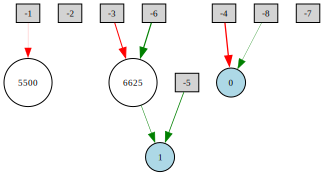

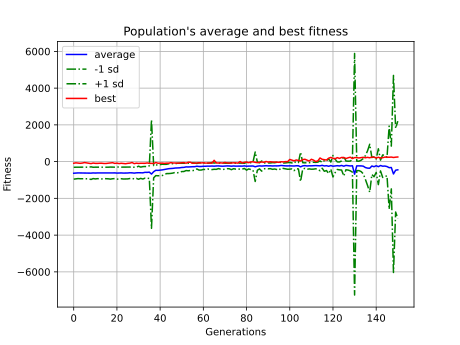

In [44]:
env_name = "lander_cont"
display(SVG(filename=f"reinforcement/{env_name}/best_network.svg"))
display(SVG(filename=f"reinforcement/{env_name}/fitness_progress.svg"))
display(SVG(filename=f"reinforcement/{env_name}/species_evolution.svg"))

In [45]:
with open("reinforcement/lander_cont/winner_genome.pkl", "rb") as f:
    winner = pickle.load(f)

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    "config_lunar_lander"
)

net = neat.nn.FeedForwardNetwork.create(winner, config)

env = gym.make('LunarLander-v3', enable_wind = True, continuous=True, render_mode='human')
state, _ = env.reset()
done = False
while not done:
    env.render()
    output = net.activate(state)
    action = np.clip(output, -1.0, 1.0)
    state, reward, done, truncated, info = env.step(action)

env.close()

## BipedalWalker

In [15]:
N_EXPERIMENTS = 3
OUTPUT_DIR = "reinforcement/walker/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def run_with_single_net_walker(net: Any, environment, max_steps=2000, N_EXPERIMENTS = 3):
    reward_sum = 0.0

    for _ in range(N_EXPERIMENTS):
        done = False
        terminated = False
        truncated = False
        state, info = environment.reset()
        step = 0
        while not (done or terminated or truncated):
            output = net.activate(state)
            action = np.clip(output, -1.0, 1.0)
            state, reward, terminated, truncated, info = environment.step(action)
            step += 1
            reward_sum += reward
            if step >= max_steps or reward < -200:
                break
                
    return reward_sum / N_EXPERIMENTS

env = gym.make("BipedalWalker-v3", render_mode=None)
main("config_walker", env, run_with_single_net_walker, output_dir = "reinforcement/walker", checkpoint="reinforcement/walker/neat-checkpoint-197", generations=50)

Restoring from checkpoint: reinforcement/walker/neat-checkpoint-197

 ****** Running generation 197 ****** 

Population's average fitness: -33.76506 stdev: 67.60603
Best fitness: 77.43802 - size: (6, 44) - species 2 - id 36566
Average adjusted fitness: 0.622
Mean genetic distance 2.208, standard deviation 0.550
Population of 200 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  197   102     75.6    0.622   104
     2  104    98     77.4    0.621   100
Total extinctions: 0
Generation time: 72.452 sec
Saving checkpoint to reinforcement/walker\neat-checkpoint-197

 ****** Running generation 198 ****** 

Population's average fitness: -30.90500 stdev: 66.13418
Best fitness: 75.12244 - size: (6, 44) - species 2 - id 36566
Average adjusted fitness: 0.568
Mean genetic distance 2.190, standard deviation 0.564
Population of 200 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====

KeyboardInterrupt: 

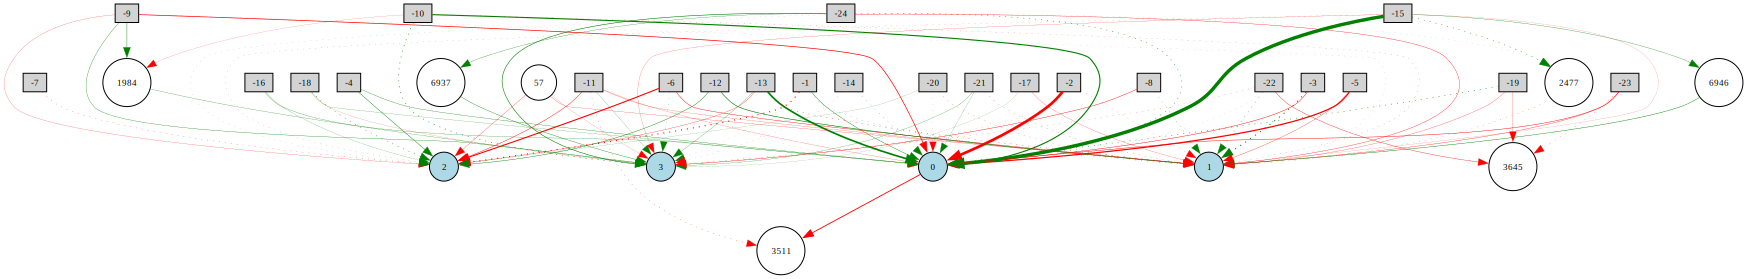

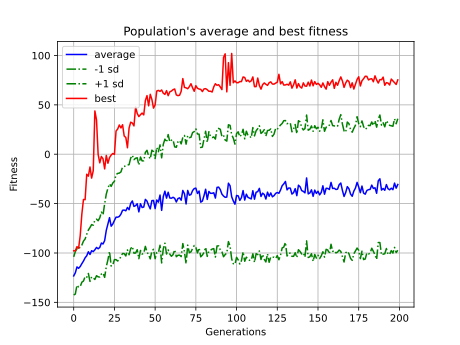

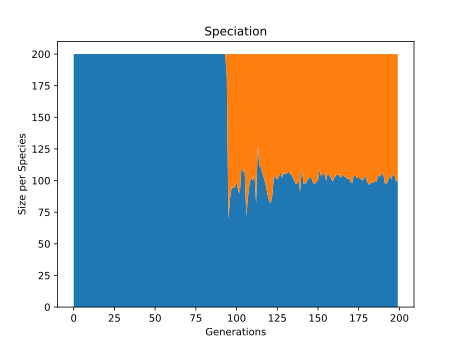

In [11]:
env_name = "walker"
display(SVG(filename=f"reinforcement/{env_name}/best_network.svg"))
display(SVG(filename=f"reinforcement/{env_name}/fitness_progress.svg"))
display(SVG(filename=f"reinforcement/{env_name}/species_evolution.svg"))

In [16]:
with open("reinforcement/walker/winner_genome.pkl", "rb") as f:
    winner = pickle.load(f)

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    "config_walker"
)

net = neat.nn.FeedForwardNetwork.create(winner, config)

env = gym.make("BipedalWalker-v3", render_mode="human")
state, _ = env.reset()
done = False
step = 0
while not done:
    env.render()
    output = net.activate(state)
    action = np.clip(output, -1.0, 1.0)
    state, reward, done, truncated, info = env.step(action)
    step+=1
    if step >= 600:
        break

env.close()